In [1]:
import json
import time
import os
import glob
import os.path as osp
import numpy as np
import pandas as pd
import torch

os.chdir('/VOLUME/nia_vent_asynchrony')

In [2]:
import module.utils as cutils

In [3]:
org = 'snu'
org = 'aju'

In [4]:
label_path = {'snu': '/VOLUME/nia_vent_asynchrony/data/raw_data/baseline_220818/label/annotations_2022_NIA_MV_SNUH.json',
'aju': '/VOLUME/nia_vent_asynchrony/data/raw_data/baseline_220818/label/annotations_2022_NIA_MV_AUMC.json'}[org]
print(org, label_path)
# label_path = '/VOLUME/nia_vent_asynchrony/data/raw_data/baseline_220818/label/annotations_2022_NIA_MV_AUMC.json'
label = cutils.load_json(label_path)

aju /VOLUME/nia_vent_asynchrony/data/raw_data/baseline_220818/label/annotations_2022_NIA_MV_AUMC.json


In [5]:
len(label)

362

In [9]:
annotations = []
for label_i in label:
    file_path = label_i['data']['csv']
    for a_i in label_i['annotations']:
        if len(a_i['result'])>0:
            df = pd.DataFrame([i['value'] for i in a_i['result']])
            df.insert(0,'file_path', file_path)
            annotations.append(df)
df = pd.concat(annotations)
df['timeserieslabels'] = df['timeserieslabels'].str[0]
df_anno = df.drop(columns='instant')
ann_df = df_anno.drop_duplicates()
ann_df = ann_df[ann_df['end']!='0NaN-NaN-NaN NaN:NaN:NaN.NaN000+00NaN']
# drop /data/upload/2/2d6fd3e8-MICU_01_*
ann_df = ann_df[ann_df['file_path'].str.contains('/data/local-files/', regex=False)]
ann_df['start'] = pd.to_datetime(ann_df['start'])
ann_df['end'] = pd.to_datetime(ann_df['end'])
ann_df['duration'] = ann_df['end']-ann_df['start']

if org=='snu':
    # snu (path: '/data/local-files/?d=SNUH/1-005-005/1-005-005_117.csv')
    ann_df['hospital_id_patient_id'] = ann_df['file_path'].str.split('/').str[-2].str.split('-').str[:2].str.join('-')
    ann_df['wav_number'] = ann_df['file_path'].str.split('/').str[-1].str.split('_').str[-1].str.replace('.csv','').astype(int)
elif org=='aju':
    # aju (path: '/data/local-files/?d=AUMC/7f1601175da2753c0a66/201904261300_201904261400.csv')
    ann_df['mv_id'] = ann_df['file_path'].str.split('/').str[-2].str.split('-').str[:2].str.join('-')
    ann_df = pd.merge(wav_dcm[['mv_id','hospital_id_patient_id']], ann_df, on=['mv_id'])# mv_id가 추가되고 wav_number가 없음
ann_df['label_annotation'] = 1 # asynchrony (true)
ann_df.loc[(ann_df['end']-ann_df['start'])<pd.Timedelta(minutes=1),'label_annotation'] = 2 # asynchrony (false)

# 0) normal 1) asynchrony (true) 2) asynchrony (false) 3) noise
# 만약 1분기준으로 à 1분이내 (false) ; 1분이상 (true) : 로 같이 구분되면 좋습니다.

ann_df.loc[ann_df['timeserieslabels']=='Noise','label_annotation'] = 3

In [10]:
ann_df

,mv_id,hospital_id_patient_id,file_path,start,end,timeserieslabels,duration,label_annotation
0,5f4806e0056fb2a7c7d7,2-002,/data/local-files/?d=AUMC/5f4806e0056fb2a7c7d7...,2019-04-26 13:00:09.859000+09:00,2019-04-26 13:00:14.242000+09:00,Ineffective effort during expiration,0 days 00:00:04.383000,2
1,5f4806e0056fb2a7c7d7,2-002,/data/local-files/?d=AUMC/5f4806e0056fb2a7c7d7...,2019-04-26 13:01:44.076000+09:00,2019-04-26 13:01:52.842000+09:00,Ineffective effort during expiration,0 days 00:00:08.766000,2
2,5f4806e0056fb2a7c7d7,2-002,/data/local-files/?d=AUMC/5f4806e0056fb2a7c7d7...,2019-04-26 13:02:01.326000+09:00,2019-04-26 13:02:18.476000+09:00,Ineffective effort during expiration,0 days 00:00:17.150000,2
3,5f4806e0056fb2a7c7d7,2-002,/data/local-files/?d=AUMC/5f4806e0056fb2a7c7d7...,2019-04-26 13:02:35.642000+09:00,2019-04-26 13:03:35.626000+09:00,Ineffective effort during expiration,0 days 00:00:59.984000,2
4,5f4806e0056fb2a7c7d7,2-002,/data/local-files/?d=AUMC/5f4806e0056fb2a7c7d7...,2019-04-26 13:03:44.159000+09:00,2019-04-26 13:04:09.892000+09:00,Noise,0 days 00:00:25.733000,3
...,...,...,...,...,...,...,...,...
4016,c11714df145297ef892f,2-010,/data/local-files/?d=AUMC/c11714df145297ef892f...,2019-06-22 15:22:03.727000+09:00,2019-06-22 15:22:12.744000+09:00,Double Triggering,0 days 00:00:09.017000,2
4017,c11714df145297ef892f,2-010,/data/local-files/?d=AUMC/c11714df145297ef892f...,2019-06-22 15:22:12.727000+09:00,2019-06-22 15:22:19.177000+09:00,Double Triggering,0 days 00:00:06.450000,2
4018,c11714df145297ef892f,2-010,/data/local-files/?d=AUMC/c11714df145297ef892f...,2019-06-22 15:22:22.194000+09:00,2019-06-22 15:22:30.411000+09:00,Double Triggering,0 days 00:00:08.217000,2
4019,c11714df145297ef892f,2-010,/data/local-files/?d=AUMC/c11714df145297ef892f...,2019-06-22 05:00:00.086000+09:00,2019-06-22 05:11:55.320000+09:00,Noise,0 days 00:11:55.234000,3


In [28]:
ann_df.to_csv(os.path.join('/VOLUME/nia_vent_asynchrony/result/baseline_220818/label', os.path.basename(label_path).replace('json','csv')), index=False)

In [7]:
df_anno['timeserieslabels'].value_counts()

Premature cycling                       5021
Ineffective effort during expiration    4374
Delayed cycling                         1684
Double Triggering                       1067
Noise                                    272
Work shifting                             15
Auto PEEP                                  3
Name: timeserieslabels, dtype: int64

In [8]:
ann_df[ann_df['end']=='0NaN-NaN-NaN NaN:NaN:NaN.NaN000+00NaN']

,file_path,start,end,timeserieslabels,duration,hospital_id_patient_id,wav_number,label_annotation


In [94]:
# df[df['end']=='0NaN-NaN-NaN NaN:NaN:NaN.NaN000+00NaN'].to_csv('/VOLUME/nia_vent_asynchrony/result/baseline_220818/label/snu_json_endtime_nan.csv', index=False)

In [9]:
ann_df['timeserieslabels'].isna().sum()

0

In [10]:
ann_df.sort_values('duration').head(20)

,file_path,start,end,timeserieslabels,duration,hospital_id_patient_id,wav_number,label_annotation
0,/data/local-files/?d=SNUH/1-002-002/1-002-002_...,2021-09-26 13:36:28.383000+09:00,2021-09-26 13:36:28.383000+09:00,Premature cycling,0 days 00:00:00,1-002,432,2
18,/data/local-files/?d=SNUH/1-002-002/1-002-002_...,2021-09-25 05:44:58.902000+09:00,2021-09-25 05:44:58.902000+09:00,Premature cycling,0 days 00:00:00,1-002,222,2
16,/data/local-files/?d=SNUH/1-002-002/1-002-002_...,2021-09-25 04:14:20.733000+09:00,2021-09-25 04:14:20.733000+09:00,Premature cycling,0 days 00:00:00,1-002,207,2
8,/data/local-files/?d=SNUH/1-002-002/1-002-002_...,2021-09-25 04:25:12.271000+09:00,2021-09-25 04:25:12.271000+09:00,Premature cycling,0 days 00:00:00,1-002,209,2
20,/data/local-files/?d=SNUH/1-002-002/1-002-002_...,2021-09-25 09:59:11.625000+09:00,2021-09-25 09:59:11.642000+09:00,Ineffective effort during expiration,0 days 00:00:00.017000,1-002,264,2
5,/data/local-files/?d=SNUH/1-002-002/1-002-002_...,2021-09-25 06:31:22.950000+09:00,2021-09-25 06:31:22.983000+09:00,Premature cycling,0 days 00:00:00.033000,1-002,230,2
15,/data/local-files/?d=SNUH/1-002-002/1-002-002_...,2021-09-25 04:26:16.839000+09:00,2021-09-25 04:26:16.889000+09:00,Premature cycling,0 days 00:00:00.050000,1-002,209,2
20,/data/local-files/?d=SNUH/1-002-002/1-002-002_...,2021-09-26 12:29:09.337000+09:00,2021-09-26 12:29:09.404000+09:00,Premature cycling,0 days 00:00:00.067000,1-002,430,2
6,/data/local-files/?d=SNUH/1-002-002/1-002-002_...,2021-09-25 10:38:11.616000+09:00,2021-09-25 10:38:11.683000+09:00,Delayed cycling,0 days 00:00:00.067000,1-002,271,2
214,/data/local-files/?d=SNUH/1-003-003/1-003-003_...,2021-08-29 17:55:52.660000+09:00,2021-08-29 17:55:52.727000+09:00,Premature cycling,0 days 00:00:00.067000,1-003,23,2


In [98]:
(ann_df['end']-ann_df['start']).describe()

count                        12410
mean     0 days 00:00:59.134505721
std      0 days 00:06:17.258641670
min                0 days 00:00:00
25%         0 days 00:00:02.567000
50%         0 days 00:00:03.033000
75%         0 days 00:00:04.817000
max         0 days 00:59:29.571000
dtype: object

In [ ]:
ann_df.groupby(['hospital_id_patient_id'])['wav_number'].max()

In [7]:
wav_dcm_path = {'snu':'/VOLUME/nia_vent_asynchrony/data/raw_data/baseline_220818/waveform_dcm/22_AIHub_26-2(Cons)_dcm(pdf)_서울대_1-002_1-021_ventilator_wav_file.csv', 
    'aju': '/VOLUME/nia_vent_asynchrony/data/raw_data/baseline_220818/waveform_dcm/22_AIHub_26-2(Cons)_dcm(pdf)_아주대_2-001_010_ventilator.xlsx'}[org]
print(wav_dcm_path)

if wav_dcm_path.split('.')[-1]=='csv':
    wav_dcm = pd.read_csv(wav_dcm_path, encoding='cp949')
if wav_dcm_path.split('.')[-1]=='xlsx':
    wav_dcm = pd.read_excel(wav_dcm_path)
    wav_dcm = wav_dcm[wav_dcm['hospital_id']==2]
wav_dcm['hospital_id_patient_id'] = wav_dcm['hospital_id'].astype(str)+'-'+(wav_dcm['patient_id'] if wav_dcm['patient_id'].dtype=='O' else wav_dcm['patient_id'].apply(lambda x : '{:03d}'.format(x)))

/VOLUME/nia_vent_asynchrony/data/raw_data/baseline_220818/waveform_dcm/22_AIHub_26-2(Cons)_dcm(pdf)_아주대_2-001_010_ventilator.xlsx


In [8]:
wav_dcm['hospital_id_patient_id'].unique()

array(['2-002', '2-003', '2-004', '2-005', '2-006', '2-007', '2-008',
       '2-009', '2-010'], dtype=object)

In [20]:
# annotation에 더 많은 wav_number가 있으면 자름 (임시)
if org=='snu':
    max_wav_df = pd.DataFrame({'hospital_id_patient_id':['1-002','1-003','1-004'], 'max_wav': [105, 378, 80]})
# elif org=='aju':
#     max_wav_df = pd.DataFrame({'hospital_id_patient_id':['2-002', '2-003', '2-004', '2-005', '2-006', '2-007', '2-008','2-009', '2-010'], 'max_wav': [105, 378, 80]})
label_ann = pd.merge(ann_df, max_wav_df)
label_ann = label_ann[label_ann.wav_number<=label_ann.max_wav]

In [21]:
max_wav_df['max_wav'].sum()*60*60/8

253350.0

In [27]:
max_wav_df

,hospital_id_patient_id,max_wav
0,1-002,105
1,1-003,378
2,1-004,80


In [23]:
label_ann

,file_path,start,end,timeserieslabels,duration,hospital_id_patient_id,wav_number,label_annotation,max_wav
0,/data/local-files/?d=SNUH/1-003-003/1-003-003_...,2021-08-30 05:58:46.870000+09:00,2021-08-30 05:58:52.170000+09:00,Premature cycling,0 days 00:00:05.300000,1-003,35,2,378
1,/data/local-files/?d=SNUH/1-003-003/1-003-003_...,2021-08-30 05:58:59.653000+09:00,2021-08-30 05:59:02.403000+09:00,Premature cycling,0 days 00:00:02.750000,1-003,35,2,378
2,/data/local-files/?d=SNUH/1-003-003/1-003-003_...,2021-08-30 05:59:04.737000+09:00,2021-08-30 05:59:07.070000+09:00,Premature cycling,0 days 00:00:02.333000,1-003,35,2,378
3,/data/local-files/?d=SNUH/1-003-003/1-003-003_...,2021-08-30 05:59:09.187000+09:00,2021-08-30 05:59:12.270000+09:00,Premature cycling,0 days 00:00:03.083000,1-003,35,2,378
4,/data/local-files/?d=SNUH/1-003-003/1-003-003_...,2021-08-30 05:59:14.870000+09:00,2021-08-30 05:59:17.137000+09:00,Premature cycling,0 days 00:00:02.267000,1-003,35,2,378
...,...,...,...,...,...,...,...,...,...
12255,/data/local-files/?d=SNUH/1-002-002/1-002-002_...,2021-09-24 03:08:23.934000+09:00,2021-09-24 03:08:25.884000+09:00,Premature cycling,0 days 00:00:01.950000,1-002,3,2,105
12256,/data/local-files/?d=SNUH/1-002-002/1-002-002_...,2021-09-24 03:08:29.818000+09:00,2021-09-24 03:08:31.734000+09:00,Premature cycling,0 days 00:00:01.916000,1-002,3,2,105
12257,/data/local-files/?d=SNUH/1-002-002/1-002-002_...,2021-09-24 03:10:45.704000+09:00,2021-09-24 03:10:48.470000+09:00,Double Triggering,0 days 00:00:02.766000,1-002,3,2,105
12258,/data/local-files/?d=SNUH/1-002-002/1-002-002_...,2021-09-24 02:54:17.500000+09:00,2021-09-24 02:54:27.984000+09:00,Noise,0 days 00:00:10.484000,1-002,1,3,105


In [24]:
ann_df.groupby('hospital_id_patient_id')['wav_number'].unique().apply(len)

hospital_id_patient_id
1-002    479
1-003    311
1-004     80
1-005     10
Name: wav_number, dtype: int64

In [11]:
ann_df

,file_path,start,end,timeserieslabels,duration,hospital_id_patient_id,wav_number,label_annotation
0,/data/local-files/?d=SNUH/1-003-003/1-003-003_...,2021-08-30 05:58:46.870000+09:00,2021-08-30 05:58:52.170000+09:00,Premature cycling,0 days 00:00:05.300000,1-003,35,2
1,/data/local-files/?d=SNUH/1-003-003/1-003-003_...,2021-08-30 05:58:59.653000+09:00,2021-08-30 05:59:02.403000+09:00,Premature cycling,0 days 00:00:02.750000,1-003,35,2
2,/data/local-files/?d=SNUH/1-003-003/1-003-003_...,2021-08-30 05:59:04.737000+09:00,2021-08-30 05:59:07.070000+09:00,Premature cycling,0 days 00:00:02.333000,1-003,35,2
3,/data/local-files/?d=SNUH/1-003-003/1-003-003_...,2021-08-30 05:59:09.187000+09:00,2021-08-30 05:59:12.270000+09:00,Premature cycling,0 days 00:00:03.083000,1-003,35,2
4,/data/local-files/?d=SNUH/1-003-003/1-003-003_...,2021-08-30 05:59:14.870000+09:00,2021-08-30 05:59:17.137000+09:00,Premature cycling,0 days 00:00:02.267000,1-003,35,2
...,...,...,...,...,...,...,...,...
5,/data/local-files/?d=SNUH/1-002-002/1-002-002_...,2021-09-24 03:08:23.934000+09:00,2021-09-24 03:08:25.884000+09:00,Premature cycling,0 days 00:00:01.950000,1-002,3,2
6,/data/local-files/?d=SNUH/1-002-002/1-002-002_...,2021-09-24 03:08:29.818000+09:00,2021-09-24 03:08:31.734000+09:00,Premature cycling,0 days 00:00:01.916000,1-002,3,2
7,/data/local-files/?d=SNUH/1-002-002/1-002-002_...,2021-09-24 03:10:45.704000+09:00,2021-09-24 03:10:48.470000+09:00,Double Triggering,0 days 00:00:02.766000,1-002,3,2
0,/data/local-files/?d=SNUH/1-002-002/1-002-002_...,2021-09-24 02:54:17.500000+09:00,2021-09-24 02:54:27.984000+09:00,Noise,0 days 00:00:10.484000,1-002,1,3


In [31]:
tmp = pd.merge(wav_dcm, ann_df, how='right')
tmp[tmp['wav_file_path'].isna()]['file_path'].nunique()
tmp[tmp['wav_file_path'].isna()]['file_path'].unique()

array(['/data/local-files/?d=SNUH/1-003-003/1-003-003_267.csv',
       '/data/local-files/?d=SNUH/1-003-003/1-003-003_266.csv',
       '/data/local-files/?d=SNUH/1-003-003/1-003-003_265.csv',
       '/data/local-files/?d=SNUH/1-003-003/1-003-003_264.csv',
       '/data/local-files/?d=SNUH/1-003-003/1-003-003_263.csv',
       '/data/local-files/?d=SNUH/1-003-003/1-003-003_262.csv',
       '/data/local-files/?d=SNUH/1-003-003/1-003-003_261.csv',
       '/data/local-files/?d=SNUH/1-003-003/1-003-003_260.csv',
       '/data/local-files/?d=SNUH/1-003-003/1-003-003_259.csv',
       '/data/local-files/?d=SNUH/1-003-003/1-003-003_257.csv',
       '/data/local-files/?d=SNUH/1-003-003/1-003-003_256.csv',
       '/data/local-files/?d=SNUH/1-003-003/1-003-003_255.csv',
       '/data/local-files/?d=SNUH/1-003-003/1-003-003_254.csv',
       '/data/local-files/?d=SNUH/1-003-003/1-003-003_253.csv',
       '/data/local-files/?d=SNUH/1-003-003/1-003-003_252.csv',
       '/data/local-files/?d=SNUH/1-003-

waveform data 불러오기

In [5]:
wavecsv_list = glob.glob('/VOLUME/nia_vent_asynchrony/data/raw_data/baseline_220818/waveform/snu/csv/*/*flow/*.csv.gz')
dest_dir = '/VOLUME/nia_vent_asynchrony/data/processed_data'

In [15]:
flow_path = '/ext_ssd/nia_vent/snu/원천_csv/*/AWF/*.csv'
# flow_path = '/VOLUME/nia_vent_asynchrony/data/raw_data/baseline_220818/waveform/aju/csv/*/AWF/*.csv'
wavecsv_list = glob.glob(flow_path)
dest_dir = '/VOLUME/nia_vent_asynchrony/data/processed_data'
# 개수 안맞아서 1-141, 1-140, 1-131, 1-090-074.csv 제외


In [116]:
# fl = glob.glob('/ext_ssd/nia_vent/snu/csv/*/*.zip')
# for fi in fl:
#     os.system(f'unzip {fi} -d {os.path.dirname(fi)} -q')

# fl = glob.glob('/ext_ssd/nia_vent/snu/csv/1-016/1-016-c-pre/*.csv')
# for fi in fl:
#     os.system(f'mv {fi} {fi.replace("flow","pre")}')

In [12]:
# flow_path = '/ext_ssd/nia_vent/snu/csv_2/*/*flow/*.csv.gz' # 1635
flow_path = '/ext_ssd/nia_vent/snu/csv/*/*flow/*.csv*' # 457
wavecsv_list = glob.glob(flow_path) # 1635
dest_dir = '/VOLUME/nia_vent_asynchrony/data/processed_data'

In [ ]:
flow_path = '/ext_ssd/nia_vent/snu/csv/*/*flow/*.csv*' # 457
wavecsv_list = glob.glob(flow_path) # 1635
dest_dir = '/VOLUME/nia_vent_asynchrony/data/processed_data'

In [22]:
flow_path = '/VOLUME/nia_vent_asynchrony/data/raw_data/baseline_220818/waveform/*/AWF/*.csv'
wavecsv_list = glob.glob(flow_path)
dest_dir = '/VOLUME/nia_vent_asynchrony/data/processed_data'

In [4]:
# 220902
flow_path = '/ext_ssd/nia_vent/aju/2-[1-2]*/AWF/*.csv*'
wavecsv_list = glob.glob(flow_path)
dest_dir = '/VOLUME/nia_vent_asynchrony/data/processed_data'

In [6]:
len(wavecsv_list)

9008

In [6]:
wavecsv_list[0]

'/ext_ssd/nia_vent/aju/2-217/AWF/2-217-027.csv'

In [5]:
tmp = pd.DataFrame({'flow_path': wavecsv_list})
tmp = tmp['flow_path'].str.split('/').str[-1].str.replace('.csv.gz','').str.replace('.csv','').str.replace('-c-flow','').str.replace('-w-flow','').str.split('-|_').apply(pd.Series)
tmp.columns = ['hospital_id', 'patient_id', 'wav_number']
tmp['hospital_id_patient_id'] = tmp['hospital_id'].astype(str)+'-'+tmp['patient_id'].astype(str)
tmp['wav_number'] = tmp['wav_number'].astype(int)
# datadf_info = pd.concat([datadf, tmp], axis=1)
tmp_flow = tmp.copy()

/tmp/ipykernel_187257/202423371.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  tmp = tmp['flow_path'].str.split('/').str[-1].str.replace('.csv.gz','').str.replace('.csv','').str.replace('-c-flow','').str.replace('-w-flow','').str.split('-|_').apply(pd.Series)


In [40]:
tmp['hospital_id_patient_id'].value_counts().sort_index()

2-001    211
2-002    123
2-003     94
2-004    133
2-006    307
        ... 
2-092     53
2-094     95
2-095    139
2-096     49
2-099     42
Name: hospital_id_patient_id, Length: 70, dtype: int64

In [61]:
flow_path

'/ext_ssd/nia_vent/aju/2-[1-2]*/AWF/*.csv*'

In [8]:
# 데이터 수 맞는지 확인
wavecsv_list_p = glob.glob(flow_path.replace('AWF','AWP').replace('flow','pre').replace('-w-','-c-'))
tmp = pd.DataFrame({'flow_path': wavecsv_list_p})
tmp = tmp['flow_path'].str.split('/').str[-1].str.replace('-c-flow','').str.replace('-c-pre','').str.split('-|_').apply(pd.Series)
tmp.columns = ['hospital_id', 'patient_id', 'wav_number']
tmp['hospital_id_patient_id'] = tmp['hospital_id'].astype(str)+'-'+tmp['patient_id'].astype(str)
tmp['wav_number'] = tmp['wav_number'].str.replace('.csv.gz','').str.replace('.csv','').astype(int)
# datadf_info = pd.concat([datadf, tmp], axis=1)
tmp_pres = tmp.copy()
tmp_pres['type'] = 'pres'
tmp_flow['type'] = 'flow'
mg = pd.merge(tmp_pres, tmp_flow, how='outer', on=tmp.columns.tolist())
gr_stat = pd.concat([tmp_pres.groupby('hospital_id_patient_id').count(),
tmp_flow.groupby('hospital_id_patient_id').count()
], axis=1)

/tmp/ipykernel_184818/2062888414.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  tmp['wav_number'] = tmp['wav_number'].str.replace('.csv.gz','').str.replace('.csv','').astype(int)


In [9]:
np.where(gr_stat.iloc[:,0]!=gr_stat.iloc[:,5])

(array([], dtype=int64),)

In [7]:
instance_length_sec = 8
instance_length_sec_td = pd.Timedelta(seconds=instance_length_sec)

def get_wave_instance_per_waveformfile(i):
    if i%100==0: print(i)
    wav = None
    wave_i = wavecsv_list[i]
    try:
        wav = pd.read_csv(wave_i, parse_dates=['Time'])
    except Exception as e:
        print(e, wave_i)
        wav = pd.read_csv(wave_i)
        wav['Time'] = pd.to_datetime(wav['Time'])
        
    if wav is None:
        print(wave_i, 'return None')
        return None

    wav['Intellivue/AWP_WAV'] = pd.read_csv(wave_i.replace('flow','pre').replace('-w-','-c-').replace('AWF','AWP'), parse_dates=['Time'])['Intellivue/AWP_WAV']
    n_instance = int((wav['Time'].max()-wav['Time'].min()).total_seconds()/instance_length_sec)
    # print(i, n_instance)

    wav_starttime = wav['Time'].min()
    df_list = []
    for tdi in range(n_instance):
        one_instance_wav = wav[(wav['Time']>=wav_starttime+tdi*instance_length_sec_td)&(wav['Time']<wav_starttime+((tdi+1)*instance_length_sec_td))]
        one_instance = pd.Series({'flow_path': wave_i, 
            'starttime': one_instance_wav.min()['Time'], 'endtime': one_instance_wav.max()['Time'], 
            'data': one_instance_wav[['Intellivue/FLOW_WAV','Intellivue/AWP_WAV']].values
            })
        df_list.append(one_instance)
    return pd.concat(df_list, axis=1).transpose()

In [9]:
import multiprocessing
since = time.time()
n_cpu = multiprocessing.cpu_count()
n_threads = 90
print(f'no. cpu existed : {n_cpu}, use {n_threads} threads')

print(len(wavecsv_list))
pool = multiprocessing.Pool(processes=n_threads)
result = pool.map(get_wave_instance_per_waveformfile, range(len(wavecsv_list)))
# result = pool.map(get_wave_instance_per_waveformfile, range(6))
pool.close()
pool.join()

print('aggregate all instances')
data = []
for i in result :
    if len(i)>0:
        data.append(i)
datadf = pd.concat(data)
print(time.time()-since)
# 7029 csv file, 70 threads, elapsed 27 mins
# 9008 csv file, 30 threads, elapsed 70 mins

no. cpu existed : 104, use 90 threads
9008
0
1300
1900
600
1200
1800
500
1100
2300
1700
400
2200
1000
1600
2100
300
900
1500
2000
2600
1400
800
200
2500
2400
100
700
3200
3900
3100
3000
3800
4500
3700
2900
2800
4400
3600
2700
4300
3500
5200
4200
3400
5100
3300
5000
4100
4900
4800
4700
4000
5800
5700
5600
6500
4600
5500
6400
5400
7100
5300
6300
6200
7000
7800
6100
6900
7700
6000
6600
7600
5900
6800
7400
7500
7300
6700
8400
8300
8200
8000
9000
8100
7200
8900
7900
8800
8700
8600
8500
aggregate all instances
2545.5665531158447


In [ ]:
# nowDate = cutils.get_today_string(False)
# dest_path = osp.join(dest_dir, org, f'instance_{org}_{len(datadf_info)}_{nowDate}.pkl')
# print(dest_path)
# datadf.to_pickle(dest_path)

In [11]:
len(wavecsv_list)

9008

In [12]:
datadf

,flow_path,starttime,endtime,data
0,/ext_ssd/nia_vent/aju/2-217/AWF/2-217-027.csv,2020-11-28 00:59:59.984053+09:00,2020-11-28 01:00:07.967388+09:00,"[[-87.0, 799.0], [-79.5, 812.5], [-68.5, 830.5..."
1,/ext_ssd/nia_vent/aju/2-217/AWF/2-217-027.csv,2020-11-28 01:00:07.984054+09:00,2020-11-28 01:00:15.967389+09:00,"[[-163.5, 864.0], [-157.5, 856.0], [-151.5, 84..."
2,/ext_ssd/nia_vent/aju/2-217/AWF/2-217-027.csv,2020-11-28 01:00:15.984056+09:00,2020-11-28 01:00:23.967391+09:00,"[[-29.0, 861.0], [-30.5, 861.0], [-31.5, 861.0..."
3,/ext_ssd/nia_vent/aju/2-217/AWF/2-217-027.csv,2020-11-28 01:00:23.984058+09:00,2020-11-28 01:00:31.967393+09:00,"[[683.0, 1393.0], [738.0, 1485.0], [792.5, 157..."
4,/ext_ssd/nia_vent/aju/2-217/AWF/2-217-027.csv,2020-11-28 01:00:31.984059+09:00,2020-11-28 01:00:39.967394+09:00,"[[309.5, 1038.0], [460.5, 1198.0], [612.0, 135..."
...,...,...,...,...
444,/ext_ssd/nia_vent/aju/2-104/AWF/2-104-024.csv,2020-06-21 11:59:11.991963+09:00,2020-06-21 11:59:19.975298+09:00,"[[-62.5, 542.0], [-67.0, 542.0], [-71.5, 542.0..."
445,/ext_ssd/nia_vent/aju/2-104/AWF/2-104-024.csv,2020-06-21 11:59:19.991965+09:00,2020-06-21 11:59:27.975300+09:00,"[[-750.5, 645.5], [-703.0, 641.0], [-659.0, 67..."
446,/ext_ssd/nia_vent/aju/2-104/AWF/2-104-024.csv,2020-06-21 11:59:27.991966+09:00,2020-06-21 11:59:35.975301+09:00,"[[541.5, 1313.5], [541.0, 1331.0], [540.5, 134..."
447,/ext_ssd/nia_vent/aju/2-104/AWF/2-104-024.csv,2020-06-21 11:59:35.991968+09:00,2020-06-21 11:59:43.975303+09:00,"[[-26.0, 519.0], [-26.0, 526.5], [-27.0, 532.5..."


In [14]:
tmp = datadf['flow_path'].str.split('/').str[-1].str.replace('-c-flow','').str.split('-|_').apply(pd.Series)
tmp.columns = ['hospital_id', 'patient_id', 'wav_number']
tmp['hospital_id_patient_id'] = tmp['hospital_id']+'-'+tmp['patient_id']
tmp['wav_number'] = tmp['wav_number'].str.replace('.csv.gz','').str.replace('.csv','').astype(int)
datadf_info = pd.concat([datadf, tmp], axis=1)
# 3157055 rows, 12min

/tmp/ipykernel_187257/3562266451.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  tmp['wav_number'] = tmp['wav_number'].str.replace('.csv.gz','').str.replace('.csv','').astype(int)


In [47]:
# datadf_info['instance_index'] = range(len(datadf_info))


In [15]:
print(len(datadf_info))
na_index = (datadf_info['data'].apply(lambda x:np.isnan(x).sum())>=480)
datadf_info_na = datadf_info[na_index]

datadf_info = datadf_info[~na_index]
print(len(datadf_info))

4013777
3160686


In [16]:
del datadf_info_na['data']
nowDate = cutils.get_today_string(False)
dest_path = osp.join(dest_dir, org, f'instance_{org}_{datadf_info_na["hospital_id_patient_id"].min()}_{datadf_info_na["hospital_id_patient_id"].max()}_{len(datadf_info)}_nan_{nowDate}.csv')
print(dest_path)
datadf_info_na.to_csv(dest_path, index=False)

/VOLUME/nia_vent_asynchrony/data/processed_data/aju/instance_aju_2-100_2-249_3160686_nan_2022-09-03.csv


In [16]:
datadf_info

,flow_path,starttime,endtime,data,hospital_id,patient_id,wav_number,hospital_id_patient_id
0,/ext_ssd/nia_vent/aju/2-217/AWF/2-217-027.csv,2020-11-28 00:59:59.984053+09:00,2020-11-28 01:00:07.967388+09:00,"[[-87.0, 799.0], [-79.5, 812.5], [-68.5, 830.5...",2,217,27,2-217
1,/ext_ssd/nia_vent/aju/2-217/AWF/2-217-027.csv,2020-11-28 01:00:07.984054+09:00,2020-11-28 01:00:15.967389+09:00,"[[-163.5, 864.0], [-157.5, 856.0], [-151.5, 84...",2,217,27,2-217
2,/ext_ssd/nia_vent/aju/2-217/AWF/2-217-027.csv,2020-11-28 01:00:15.984056+09:00,2020-11-28 01:00:23.967391+09:00,"[[-29.0, 861.0], [-30.5, 861.0], [-31.5, 861.0...",2,217,27,2-217
3,/ext_ssd/nia_vent/aju/2-217/AWF/2-217-027.csv,2020-11-28 01:00:23.984058+09:00,2020-11-28 01:00:31.967393+09:00,"[[683.0, 1393.0], [738.0, 1485.0], [792.5, 157...",2,217,27,2-217
4,/ext_ssd/nia_vent/aju/2-217/AWF/2-217-027.csv,2020-11-28 01:00:31.984059+09:00,2020-11-28 01:00:39.967394+09:00,"[[309.5, 1038.0], [460.5, 1198.0], [612.0, 135...",2,217,27,2-217
...,...,...,...,...,...,...,...,...
444,/ext_ssd/nia_vent/aju/2-104/AWF/2-104-024.csv,2020-06-21 11:59:11.991963+09:00,2020-06-21 11:59:19.975298+09:00,"[[-62.5, 542.0], [-67.0, 542.0], [-71.5, 542.0...",2,104,24,2-104
445,/ext_ssd/nia_vent/aju/2-104/AWF/2-104-024.csv,2020-06-21 11:59:19.991965+09:00,2020-06-21 11:59:27.975300+09:00,"[[-750.5, 645.5], [-703.0, 641.0], [-659.0, 67...",2,104,24,2-104
446,/ext_ssd/nia_vent/aju/2-104/AWF/2-104-024.csv,2020-06-21 11:59:27.991966+09:00,2020-06-21 11:59:35.975301+09:00,"[[541.5, 1313.5], [541.0, 1331.0], [540.5, 134...",2,104,24,2-104
447,/ext_ssd/nia_vent/aju/2-104/AWF/2-104-024.csv,2020-06-21 11:59:35.991968+09:00,2020-06-21 11:59:43.975303+09:00,"[[-26.0, 519.0], [-26.0, 526.5], [-27.0, 532.5...",2,104,24,2-104


In [74]:
480*2

960

In [17]:
nowDate = cutils.get_today_string(False)
dest_path = osp.join(dest_dir, org, f'instance_{org}_{datadf_info["hospital_id_patient_id"].min()}_{datadf_info["hospital_id_patient_id"].max()}_{len(datadf_info)}_{nowDate}.pkl')
print(dest_path)
datadf_info.to_pickle(dest_path)

/VOLUME/nia_vent_asynchrony/data/processed_data/aju/instance_aju_2-100_2-249_3160686_2022-09-03.pkl


In [34]:
datadf_info['instance_index'] = range(len(datadf_info))
def annotate_each_label(label_num:int):
    common_keys = ['hospital_id_patient_id','wav_number'] if 'wav_number' in ann_df.columns else ['hospital_id_patient_id']
    ann_data = pd.merge(datadf_info, ann_df[ann_df['label_annotation']==label_num], on=common_keys)
    cond1 = (ann_data['starttime']<=ann_data['start'])&(ann_data['endtime']>=ann_data['end']) # anntation이 instance 에 포함
    cond2 = (ann_data['starttime']<=ann_data['start'])&(ann_data['endtime']>=ann_data['start']) # annotation start가 instance 에 포함
    cond3 = (ann_data['starttime']<=ann_data['end'])&(ann_data['endtime']>=ann_data['end']) # annotation end가 instance 에 포함
    ann_index = ann_data[cond1|cond2|cond3]['instance_index']
    return ann_index
ann_index_3 = annotate_each_label(3)
ann_index_2 = annotate_each_label(2)
ann_index_1 = annotate_each_label(1)
print(len(ann_index_1), len(ann_index_2), len(ann_index_3))
datadf_info['label'] = 0
datadf_info.loc[datadf_info['instance_index'].isin(ann_index_3),'label'] = 3
datadf_info.loc[datadf_info['instance_index'].isin(ann_index_2),'label'] = 2
datadf_info.loc[datadf_info['instance_index'].isin(ann_index_1),'label'] = 1
print(datadf_info.label.value_counts())
# datadf_info = datadf_info.loc[:,~datadf_info.columns.isin(['hospital_id','patient_id'])] # aju

/tmp/ipykernel_131014/640458757.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datadf_info['instance_index'] = range(len(datadf_info))


16 3274 838
0    291582
2      3069
3       770
1        16
Name: label, dtype: int64


/tmp/ipykernel_131014/640458757.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datadf_info['label'] = 0
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [ ]:
datadf_info.label.value_counts()

0    242157
2       373
1        64
3        24
Name: label, dtype: int64

In [145]:
(datadf_info.groupby('hospital_id_patient_id')['endtime'].max()-datadf_info.groupby('hospital_id_patient_id')['starttime'].min()).dt.total_seconds().sum()/8

259680.995570375

In [128]:
4.287119e+05

428711.9

In [47]:
dest_dir = '/VOLUME/nia_vent_asynchrony/data/processed_data'

In [55]:
nowDate = cutils.get_today_string(False)
dest_path = osp.join(dest_dir, org, f'instance_with_label_{org}_{len(datadf_info)}_{nowDate}.pkl')
print(dest_path)
datadf_info.to_pickle(dest_path)

/VOLUME/nia_vent_asynchrony/data/processed_data/snu/instance_with_label_snu_3157055_2022-08-25.pkl


In [3]:
import pandas as pd
# org = 'aju'
# datadf_info = pd.read_pickle('/VOLUME/nia_vent_asynchrony/data/processed_data/aju/instance_with_label_aju_2022-08-23.pkl')
org = 'snu'
# datadf_info = pd.read_pickle('/VOLUME/nia_vent_asynchrony/data/processed_data/snu/instance_with_label_snu.pkl')
datadf_info = pd.read_pickle('/VOLUME/nia_vent_asynchrony/data/processed_data/snu/instance_snu_2022-08-23.pkl')

# 

In [4]:
from sklearn.preprocessing import RobustScaler


In [5]:
def scale_wv(x):
    ls = []
    for i in range(2):
        sc = RobustScaler()
        ls.append(sc.fit_transform(x[:,i].reshape(-1,1)).reshape(-1))
    return np.array(ls).transpose()


In [66]:
# datadf_info['data'] = datadf_info['data'].apply(lambda x : pd.DataFrame(x).interpolate(limit_direction='both').values) # missing value interporation
# print(len(datadf_info))
# datadf_info = datadf_info[datadf_info['data'].apply(lambda x : np.isnan(x).sum())==0]
# print(len(datadf_info))
# datadf_info['data'] = datadf_info['data'].apply(scale_wv) # robust scaling

3157055
3146719


In [ ]:
datadf_info

In [8]:
datadf_info['data'].apply(lambda x : np.isnan(x).sum()).value_counts()

0      2691039
4        96102
2        84727
8        73487
6        69133
        ...   
684          1
403          1
576          1
537          1
363          1
Name: data, Length: 548, dtype: int64

In [9]:
print(len(datadf_info))
datadf_info = datadf_info[datadf_info['data'].apply(lambda x : np.isnan(x).sum())<480]
print(len(datadf_info))

3157055
3145286


In [29]:
def preprocess(i):
    if i%10000==0: print(i)
    data = datadf_info.iloc[i]['data']
    data = pd.DataFrame(data).interpolate(limit_direction='both').values
    if np.isnan(data).sum()>0:
        return np.nan
    return scale_wv(data)

In [ ]:
# datadf_info['data'] = datadf_info['data'].apply(lambda x : pd.DataFrame(x).interpolate(limit_direction='both').values) # missing value interporation
# print(len(datadf_info))
# datadf_info = datadf_info[datadf_info['data'].apply(lambda x : np.isnan(x).sum())==0]
# print(len(datadf_info))
# datadf_info['data'] = datadf_info['data'].apply(scale_wv) # robust scaling

In [30]:
import multiprocessing
since = time.time()
n_cpu = multiprocessing.cpu_count()
n_threads = 40
print(f'no. cpu existed : {n_cpu}, use {n_threads} threads')

print(len(datadf_info))
pool = multiprocessing.Pool(processes=n_threads)
result = pool.map(preprocess, range(len(datadf_info)))
# result = pool.map(preprocess, range(10))
pool.close()
pool.join()

# print('aggregate all instances')
# data = []
# for i in result :
#     if len(i)>0:
#         data.append(i)
# datadf = pd.concat(data)
print(time.time()-since)
# 7029 csv file, 70 threads, elapsed 27 mins

no. cpu existed : 104, use 40 threads
3145286
0
590000
20000
610000
40000
630000
60000
650000
80000
670000
100000
690000
120000
710000
750000
730000
140000
160000
770000
180000
200000
220000
240000
260000
280000
300000
320000
340000
360000
380000
400000
440000
420000
480000
460000
500000
520000
540000
560000
580000
640000
600000
10000
620000
30000
70000
660000
50000
680000
90000
720000
700000
110000
150000
760000
740000
780000
130000
170000
190000
210000
230000
250000
270000
290000
310000
330000
350000
390000
370000
450000
430000
410000
490000
470000
510000
530000
550000
570000
790000
1160000
810000
1180000
830000
1200000
850000
1220000
870000
1240000890000

1260000
910000
1280000
930000
1300000
950000
1320000
970000
990000
1340000
1360000
1010000
1380000
1030000
1400000
1050000
1420000
1070000
1440000
1090000
1460000
1110000
1130000
1480000
1500000
1520000
800000
1150000
820000
1170000
1540000
1190000
840000
1560000
1210000
860000
880000
1230000
900000
1250000
920000
1270000
1290000
9

<AxesSubplot:>

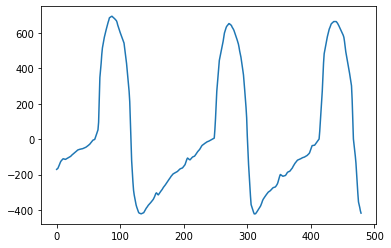

In [35]:
pd.DataFrame(datadf_info['data'].iloc[-1]).loc[:,0].plot()

In [36]:
pd.DataFrame(tmp.iloc[-1].iloc[0]).iloc[:,0].plot()

ValueError: DataFrame constructor not properly called!

In [37]:
datadf_info['data_scaled'] = result

ValueError: Length of values (695) does not match length of index (295437)

In [38]:
datadf_info

,flow_path,starttime,endtime,data,hospital_id,patient_id,wav_number,hospital_id_patient_id,instance_index,label
0,/VOLUME/nia_vent_asynchrony/data/raw_data/base...,2019-04-25 14:29:59.993773+09:00,2019-04-25 14:30:07.977108+09:00,"[[15.5, 507.5], [77.5, 538.5], [140.5, 570.0],...",2,002,1,2-002,0,0
1,/VOLUME/nia_vent_asynchrony/data/raw_data/base...,2019-04-25 14:30:07.993774+09:00,2019-04-25 14:30:15.977109+09:00,"[[234.5, 617.5], [172.5, 586.5], [109.5, 555.0...",2,002,1,2-002,1,0
2,/VOLUME/nia_vent_asynchrony/data/raw_data/base...,2019-04-25 14:30:15.993776+09:00,2019-04-25 14:30:23.977111+09:00,"[[47.5, 524.0], [-15.5, 492.5], [-77.5, 461.5]...",2,002,1,2-002,2,0
3,/VOLUME/nia_vent_asynchrony/data/raw_data/base...,2019-04-25 14:30:23.993778+09:00,2019-04-25 14:30:31.977113+09:00,"[[-140.5, 430.0], [-202.5, 399.0], [-234.5, 38...",2,002,1,2-002,3,0
4,/VOLUME/nia_vent_asynchrony/data/raw_data/base...,2019-04-25 14:30:31.993779+09:00,2019-04-25 14:30:39.977114+09:00,"[[-172.5, 413.5], [-109.5, 445.0], [-47.5, 476...",2,002,1,2-002,4,0
...,...,...,...,...,...,...,...,...,...,...
219,/VOLUME/nia_vent_asynchrony/data/raw_data/base...,2019-06-25 13:29:11.993043+09:00,2019-06-25 13:29:19.976378+09:00,"[[-305.0, 653.0], [-305.0, 653.0], [-305.0, 64...",2,010,81,2-010,295432,0
220,/VOLUME/nia_vent_asynchrony/data/raw_data/base...,2019-06-25 13:29:19.993045+09:00,2019-06-25 13:29:27.976380+09:00,"[[715.0, 518.0], [736.0, 530.0], [756.5, 544.0...",2,010,81,2-010,295433,0
221,/VOLUME/nia_vent_asynchrony/data/raw_data/base...,2019-06-25 13:29:27.993046+09:00,2019-06-25 13:29:35.976381+09:00,"[[-258.0, 620.0], [-255.0, 620.0], [-251.0, 61...",2,010,81,2-010,295434,0
222,/VOLUME/nia_vent_asynchrony/data/raw_data/base...,2019-06-25 13:29:35.993048+09:00,2019-06-25 13:29:43.976383+09:00,"[[-5.5, 418.0], [-3.0, 410.0], [-0.5, 401.5], ...",2,010,81,2-010,295435,0


In [54]:
datadf_info['data'].sample(300).apply(lambda x : np.isnan(x).sum()).value_counts()

0    300
Name: data, dtype: int64

In [53]:
datadf_info = datadf_info.drop(columns='data').rename(columns={'data_scaled':'data'})

In [55]:
datadf_info

,flow_path,starttime,endtime,hospital_id,patient_id,wav_number,hospital_id_patient_id,instance_index,data
0,/ext_ssd/nia_vent/snu/원천_csv/1-094/AWF/1-094-2...,2022-02-04 17:59:57.317517+09:00,2022-02-04 18:00:05.301010+09:00,1,094,239,1-094,0,"[[-0.0556405785238513, -0.15277775324911563], ..."
1,/ext_ssd/nia_vent/snu/원천_csv/1-094/AWF/1-094-2...,2022-02-04 18:00:05.317677+09:00,2022-02-04 18:00:13.301170+09:00,1,094,239,1-094,1,"[[-2.199993984525559, -0.02595938997561205], [..."
2,/ext_ssd/nia_vent/snu/원천_csv/1-094/AWF/1-094-2...,2022-02-04 18:00:13.317837+09:00,2022-02-04 18:00:21.301330+09:00,1,094,239,1-094,2,"[[0.170819843184988, 2.660673735428073], [0.16..."
3,/ext_ssd/nia_vent/snu/원천_csv/1-094/AWF/1-094-2...,2022-02-04 18:00:21.317997+09:00,2022-02-04 18:00:29.301490+09:00,1,094,239,1-094,3,"[[-0.0824748255934783, -0.15384618609211642], ..."
4,/ext_ssd/nia_vent/snu/원천_csv/1-094/AWF/1-094-2...,2022-02-04 18:00:29.318157+09:00,2022-02-04 18:00:37.301650+09:00,1,094,239,1-094,4,"[[-2.4556938140270854, 0.2456142112049542], [-..."
...,...,...,...,...,...,...,...,...,...
445,/ext_ssd/nia_vent/snu/원천_csv/1-093/AWF/1-093-0...,2022-01-24 10:59:17.472019+09:00,2022-01-24 10:59:25.455512+09:00,1,093,24,1-093,3157050,"[[0.9999969903812586, 0.9934308090887937], [0...."
446,/ext_ssd/nia_vent/snu/원천_csv/1-093/AWF/1-093-0...,2022-01-24 10:59:25.472179+09:00,2022-01-24 10:59:33.455672+09:00,1,093,24,1-093,3157051,"[[-1.1486511350514548, -0.0045330797580059486]..."
447,/ext_ssd/nia_vent/snu/원천_csv/1-093/AWF/1-093-0...,2022-01-24 10:59:33.472339+09:00,2022-01-24 10:59:41.455832+09:00,1,093,24,1-093,3157052,"[[5.305342458143606, 1.013029330717304], [5.01..."
448,/ext_ssd/nia_vent/snu/원천_csv/1-093/AWF/1-093-0...,2022-01-24 10:59:41.472499+09:00,2022-01-24 10:59:49.455992+09:00,1,093,24,1-093,3157053,"[[-1.3719016762377774, -0.019953476000729026],..."


In [39]:
dest_dir = '/VOLUME/nia_vent_asynchrony/data/processed_data'
nowDate = cutils.get_today_string(False)
dest_path = osp.join(dest_dir, org, f'instance_with_label_{org}_{len(datadf_info)}_{nowDate}.pkl')
print(dest_path)
datadf_info.to_pickle(dest_path)

/VOLUME/nia_vent_asynchrony/data/processed_data/aju/instance_with_label_aju_295437_2022-09-01.pkl


In [58]:
2182147/128

17048.0234375